##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 卷积神经网络（Convolutional Neural Network, CNN）

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://tensorflow.google.cn/tutorials/images/cnn"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png" />在 tensorFlow.google.cn 上查看</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/images/cnn.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png" />在 Google Colab 中运行</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/images/cnn.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 上查看源代码</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/tutorials/images/cnn.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png" />下载 notebook</a>
  </td>
</table>

Note: 我们的 TensorFlow 社区翻译了这些文档。因为社区翻译是尽力而为， 所以无法保证它们是最准确的，并且反映了最新的
[官方英文文档](https://tensorflow.google.cn/?hl=en)。如果您有改进此翻译的建议， 请提交 pull request 到
[tensorflow/docs-l10n](https://github.com/tensorflow/docs-l10n) GitHub 仓库。要志愿地撰写或者审核译文，请加入
[docs-zh-cn@tensorflow.org Google Group](https://groups.google.com/a/tensorflow.org/forum/#!forum/docs-zh-cn)。

### 导入 TensorFlow

In [33]:
import tensorflow as tf
import numpy as np

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

### 下载并准备 CIFAR10 数据集


CIFAR10 数据集包含 10 类，共 60000 张彩色图片，每类图片有 6000 张。此数据集中 50000 个样例被作为训练集，剩余 10000 个样例作为测试集。类之间相互独立，不存在重叠的部分。

In [21]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

# 将像素的值标准化至0到1的区间内。
train_images, test_images = train_images / 255.0, test_images / 255.0

# 添加一个维度
train_images, test_images = train_images[..., tf.newaxis], test_images[..., tf.newaxis]

### 验证数据

我们将测试集的前 25 张图片和类名打印出来，来确保数据集被正确加载。


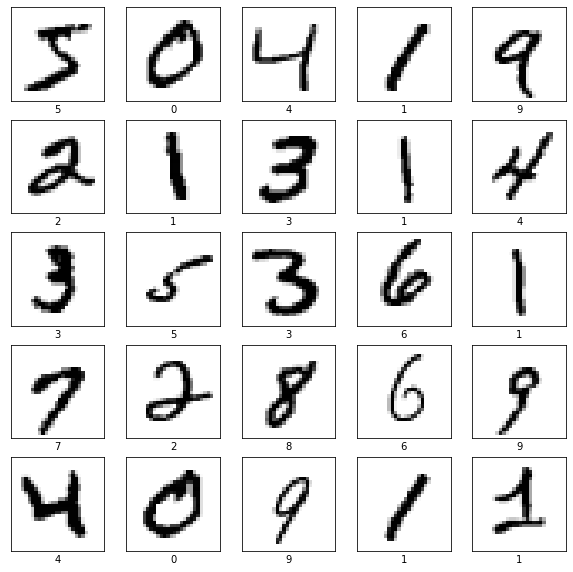

In [3]:
class_names = [str(_) for _ in range(10)]

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # 由于 CIFAR 的标签是 array， 
    # 因此您需要额外的索引（index）。
    plt.xlabel(class_names[train_labels[i]])
plt.show()

### 构造卷积神经网络模型

下方展示的 6 行代码声明了了一个常见卷积神经网络，由几个 [Conv2D](https://tensorflow.google.cn/api_docs/python/tf/keras/layers/Conv2D) 和 [MaxPooling2D](https://tensorflow.google.cn/api_docs/python/tf/keras/layers/MaxPool2D) 层组成。

CNN 的输入是张量 (Tensor) 形式的 (image_height, image_width, color_channels)，包含了图像高度、宽度及颜色信息。不需要输入 batch size。如果您不熟悉图像处理，颜色信息建议您使用 RGB 色彩模式，此模式下，`color_channels` 为 `(R,G,B)` 分别对应 RGB 的三个颜色通道（color channel）。在此示例中，我们的 CNN 输入，CIFAR 数据集中的图片，形状是 `(32, 32, 3)`。您可以在声明第一层时将形状赋值给参数 `input_shape` 。


In [10]:
model = models.Sequential()
'''
filters卷积核个数, 此处设置32个
3*3的卷积核
'''
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

我们声明的 CNN 结构是：

In [11]:
model.summary() 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


在上面的结构中，您可以看到每个 Conv2D 和 MaxPooling2D 层的输出都是一个三维的张量 (Tensor)，其形状描述了 (height, width, channels)。越深的层中，宽度和高度都会收缩。每个 Conv2D 层输出的通道数量 (channels) 取决于声明层时的第一个参数（如：上面代码中的 32 或 64）。这样，由于宽度和高度的收缩，您便可以（从运算的角度）增加每个 Conv2D 层输出的通道数量 (channels)。 

### 增加 Dense 层
*Dense 层等同于全连接 (Full Connected) 层。*   
在模型的最后，您将把卷积后的输出张量（本例中形状为 (4, 4, 64)）传给一个或多个 Dense 层来完成分类。Dense 层的输入为向量（一维），但前面层的输出是3维的张量 (Tensor)。因此您需要将三维张量展开 (flatten) 到1维，之后再传入一个或多个 Dense 层。CIFAR 数据集有 10 个类，因此您最终的 Dense 层需要 10 个输出及一个 softmax 激活函数。

In [12]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

查看完整的 CNN 结构：

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

可以看出，在被传入两个 Dense 层之前，形状为 (4, 4, 64) 的输出被展平成了形状为 (1024) 的向量。

### 编译并训练模型

In [ ]:
rh_test = train_images.copy()
rh_test[..., tf.newaxis].shape

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0098 - accuracy: 0.9970 - val_loss: 0.0385 - val_accuracy: 0.9913
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0070 - accuracy: 0.9977 - val_loss: 0.0433 - val_accuracy: 0.9910
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0061 - accuracy: 0.9981 - val_loss: 0.0408 - val_accuracy: 0.9913
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0068 - accuracy: 0.9978 - val_loss: 0.0451 - val_accuracy: 0.9913
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0062 - accuracy: 0.9980 - val_loss: 0.0380 - val_accuracy: 0.9922
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0057 - accuracy: 0.9982 - val_loss: 0.0490 - val_accuracy: 0.9905
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0048 - accuracy: 0.9983 - val_loss: 0.0501 - val_accuracy:

### 评估模型

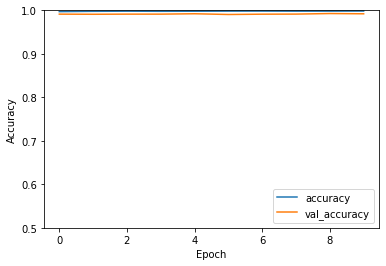

313/313 - 0s - loss: 0.0449 - accuracy: 0.9921


In [23]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [42]:
print('该模型的准确率为：', test_acc)

该模型的准确率为： 0.9921000003814697


我们搭建的简单的 CNN 模型在测试集上可以达到 70% 的准确率。对于只有几行的代码来说效果不错！对于另一种 CNN 结构可参考另一个使用的基于 Keras 子类 API 和 `tf.GradientTape` 的样例 [here](https://tensorflow.google.cn/tutorials/quickstart/advanced)。

该图片的预测值为： 2


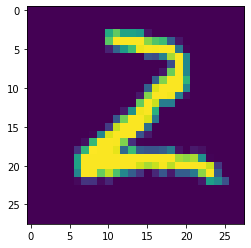

In [41]:
def predictSingleImage(img):
    plt.imshow(img[:, :, 0])
    predictions = model.predict(img[tf.newaxis, ..., tf.newaxis])
    ans = np.argmax(predictions[0])
    print("该图片的预测值为：", ans)

predictSingleImage(test_images[996])